# 2-2-2 PC Network
Purpose: This is to compare to Brian C.'s results.

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
from ipywidgets import FloatProgress
from tqdm import tqdm

%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

np.set_printoptions(precision=4)

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:5") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [646]:
# This creates a dataset
n_classes = 3
sensory_dim = 10

seed = 29512
torch.manual_seed(seed)
np.random.seed(seed)
B = torch.eye(n_classes, dtype=torch.float32, device=device)
X = 3.*(torch.rand((sensory_dim, n_classes), dtype=torch.float32, device=device) - 0.5)
A = X.T
print('Input vectors')
print(A)
print('Target vectors')
print(B)

Input vectors
tensor([[-0.9603, -0.4576,  0.4044, -1.2430,  0.9161, -1.0841,  1.4800,  0.3566,
         -0.9265,  1.4660],
        [ 1.0378, -0.9411,  0.5041, -0.9879, -0.5247, -0.6067, -1.1834,  1.0809,
         -0.1987,  0.5158],
        [-0.8338, -1.0187, -1.1763,  0.0819,  1.3077, -1.4373,  0.1374,  0.6046,
          1.1388,  1.1284]])
Target vectors
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [64]:
class SimpleDataset(Dataset):
    def __init__(self, A, B, n=300, Anoise=0.1, Bnoise=0.):
        self.samples = []
        self.n_classes = len(A)
        self.input_dim = len(A[0])
        for i in range(n):
            r = np.random.randint(self.n_classes)
            sample = [A[r]+Anoise*torch.randn_like(A[r]), B[r]+Bnoise*torch.randn_like(B[r])]
            #sample = [A[r]+noise*torch.randn_like(A[r]), B[r]+noise*torch.randn_like(B[r])]
            self.samples.append(sample)
        
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)
    
    def Inputs(self):
        x = []
        for s in self.samples:
            x.append(s[0])
        return torch.stack(x)
    
    def Targets(self):
        t = []
        for s in self.samples:
            t.append(s[1])
        return torch.stack(t)
            
    def InputsOfClass(self, c):
        x = []
        for s in self.samples:
            if torch.argmax(s[1])==c:
                x.append(s[0])
        return torch.stack(x)
    
    def ClassMean(self):
        xmean = []
        for c_idx in range(self.n_classes):
            classmean = torch.mean(self.InputsOfClass(c_idx), axis=0)
            xmean.append(classmean)
        return torch.stack(xmean)
            
    def Plot(self, labels=[], idx=(1,2), equal=True):
        X = self.Inputs()
        if len(labels)==0:
            labels = self.Targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = torch.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X.cpu()[:,idx[0]], X.cpu()[:,idx[1]], color=colours, marker='.')

        if equal:
            plt.axis('equal');

In [66]:
A = torch.tensor([[1,2],[3,4]], dtype=torch.float)
blah = SimpleDataset(A, A, n=200, Anoise=0.1, Bnoise=0.1)

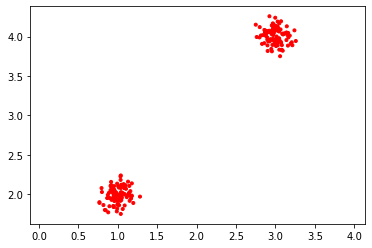

In [67]:
blah.Plot(idx=(0,1));

# Create Network

In [68]:
ds = SimpleDataset(A, A, n=100, Anoise=0.05, Bnoise=0.05)
dl = DataLoader(ds, batch_size=25, shuffle=True)

In [69]:
mid_dim = 2
net = PCNetwork.PCNetwork(device=device)
net.AddLayer(PCLayer.PCLayer(n=ds.input_dim, device=device))  # [0] v0 input

net.AddLayer(PCLayer.PCLayer(n=ds.n_classes, device=device))  # [1] e1 error
net.AddLayer(PCLayer.PCLayer(n=ds.n_classes, device=device))  # [2] v1 class

af0 = 'identity'
af = 'identity'
sym_1to1 = True
sym_general = True
net.Connect(v_idx=0, e_idx=1, type='general', sym=sym_general, act_text=af0)
net.Connect(e_idx=1, v_idx=2, type='general', sym=sym_1to1, act_text=af)

net.SetTau(0.1)

# Training

In [101]:
net.ClearHistory()
net.Probe(True)
net.Learning(True)
net.SetGamma(1.)
mult = 0.1

# Connection (v0)--(e1)
#net.con[0].SetIdentity() # v0-e1
net.con[0].SetRandom(random=mult) # v0-e1
net.con[1].SetIdentity()

net.SetDynamicWeightDecay(0.01, 0.8)
net.SetActivityDecay(0.0)
net.SetBlackout(0.)

In [102]:
net.con[1].M

tensor([[1., 0.],
        [0., 1.]])

## Train it

In [107]:
net.Reset()
net.con[0].Learning(True)   # v0 <-> e1
net.con[1].Learning(False)  # e1 <-> v1
net.SetDynamicWeightDecay(0.0, 0.0)
net.Learn(dl, T=1., epochs=10)

100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


In [108]:
print(net.con[0].M)
print(net.con[0].W)

tensor([[0.9778, 0.0315],
        [0.0138, 0.9726]])
tensor([[0.9778, 0.0138],
        [0.0315, 0.9726]])


In [109]:
print(net.con[1].M)
print(net.con[1].W)

tensor([[1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.]])


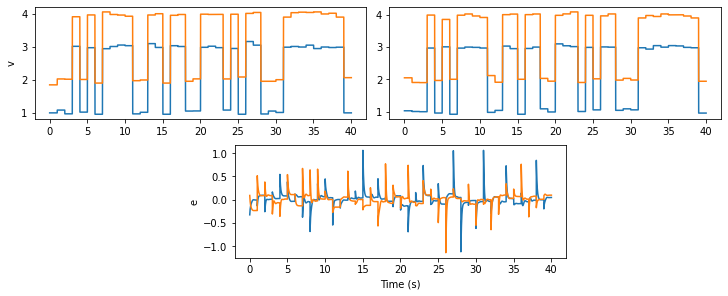

In [110]:
net.Plot();

## Alternating Layers

In [843]:
iters = 2
T = 3.
e = 1
orig_init_wd = 0.01
for k in range(iters):
    wd = orig_init_wd * (0.2**k)

    # Between-layers
    net.Reset()
    net.Learning(True)
    net.con[0].Learning(True)
    net.con[1].Learning(False)
    net.con[2].Learning(True)
    net.con[3].Learning(False)
    net.SetDynamicWeightDecay(wd, 0.8)
    net.Learn(dl, T=T, epochs=e)

    # 1:1
    net.Reset()
    net.Learning(True)
    net.con[0].Learning(False)
    net.con[1].Learning(True)
    net.con[2].Learning(False)
    net.con[3].Learning(True)
    net.SetDynamicWeightDecay(wd, 0.8)
    net.Learn(dl, T=T, epochs=e)

Epoch: 0 weight decay = 0.01
Epoch: 0 weight decay = 0.01
Epoch: 0 weight decay = 0.002
Epoch: 0 weight decay = 0.002


In [635]:
iters = 2
T = 5.
e = 1
orig_init_wd = 0.01
for k in range(iters):
    wd = orig_init_wd * (0.2**k)

    # Between-layers
    net.Reset()
    net.Learning(True)
    net.con[0].Learning(True)
    net.con[1].Learning(False)
    net.con[2].Learning(True)
    net.con[3].Learning(False)
    net.SetDynamicWeightDecay(wd, 0.8)
    net.Learn(dl, T=T, epochs=e)

    # 1:1
#     net.Reset()
#     net.Learning(True)
#     net.con[0].Learning(False)
#     net.con[1].Learning(True)
#     net.con[2].Learning(False)
#     net.con[3].Learning(True)
#     net.SetDynamicWeightDecay(wd, 0.8)
#     net.Learn(dl, T=T, epochs=e)

Epoch: 0 weight decay = 0.01
Epoch: 0 weight decay = 0.002


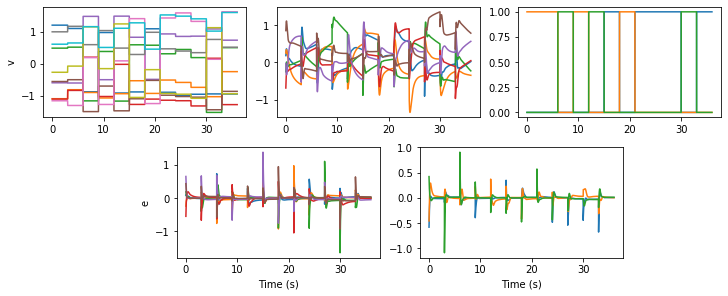

In [844]:
net.Plot();

## Weights

In [865]:
#print(net.con[0].M)
print(torch.sum(torch.abs(net.con[0].M)))
#print(net.con[0].W.transpose(1,0))
#print(net.con[1].M)
print(torch.sum(torch.abs(net.con[1].M)))
#print(net.con[1].W.transpose(1,0))
#print(net.con[2].M)
print(torch.sum(torch.abs(net.con[2].M)))
#print(net.con[2].W.transpose(1,0))
#print(net.con[3].M)
print(torch.sum(torch.abs(net.con[3].M)))
#print(net.con[3].W.transpose(1,0))

tensor(26.3681)
tensor(1.8989)
tensor(6.3994)
tensor(0.4481)


# Classification

In [882]:
net.Reset(random=0.2)
net.SetActivityDecay( 0.0 )
y = net.Predict(ds.Inputs(), T=10., dt=0.005)
print(y[:15])
print(ds.Targets()[:15])

tensor([[-0.0097, -0.0095,  0.0060],
        [-0.0016, -0.0050,  0.0030],
        [-0.0312, -0.0286,  0.0077],
        [-0.0136, -0.0083,  0.0063],
        [-0.0389, -0.0338,  0.0080],
        [-0.0360, -0.0306,  0.0071],
        [-0.0460, -0.0372,  0.0076],
        [-0.0108, -0.0009, -0.0010],
        [-0.0254, -0.0264,  0.0058],
        [-0.0071, -0.0078,  0.0037],
        [-0.0307, -0.0129,  0.0004],
        [-0.0154, -0.0023, -0.0015],
        [-0.0205, -0.0075, -0.0033],
        [ 0.0003, -0.0043,  0.0040],
        [-0.0257, -0.0127, -0.0033]])
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]])


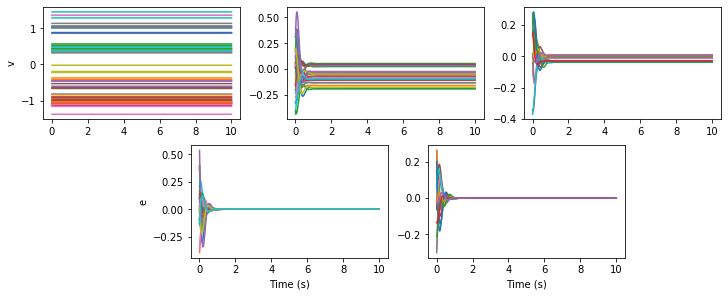

In [883]:
net.Plot(idx=[1,2,3,4,5]);

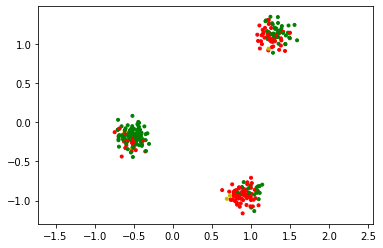

In [848]:
ds.Plot(labels=y, idx=(4,8))

# Generation

In [559]:
net.Reset(random=1.)
net.SetActivityDecay(0.02)
X = net.Generate(ds.Targets(), T=15.)

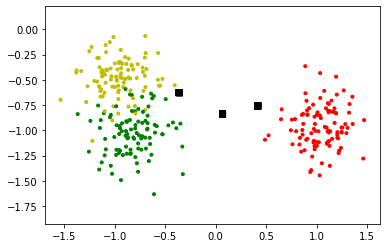

In [560]:
sidx = (0,1)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);

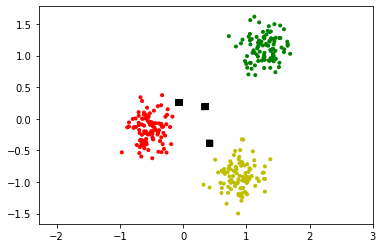

In [561]:
sidx = (4,8)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);